# Predicting house prices

This script uses the daft.ie ad data enriched by openstreetmap data to predict house prices. 

## Describing and cleaning the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

df_ads = pd.read_pickle('df_ads_mapdata.pkl')
df_ads.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12272 entries, 0 to 12271
Data columns (total 40 columns):
ad_id                 12272 non-null object
ad_ids                12272 non-null object
advertising_type      2016 non-null object
area                  12272 non-null object
bathrooms             12195 non-null float64
beds                  12195 non-null float64
ber_classification    9458 non-null object
county                12272 non-null object
currency              12195 non-null object
dist_to_centre        12272 non-null float64
environment           12272 non-null object
facility              12195 non-null object
latitude              12272 non-null float64
longitude             12272 non-null float64
no_of_photos          12272 non-null int64
no_of_units           97 non-null float64
open_viewing          12272 non-null object
page_name             12272 non-null object
platform              12272 non-null object
price                 12106 non-null float64
price_type

In [2]:
df_ads['published_date'] = pd.to_datetime(df_ads.published_date)
df_ads['month'] = df_ads['published_date'].dt.to_period('M')

df_ads['parking'] = df_ads.facility.str.contains('parking', case=False, regex=False)


Selecting the relevant variables and describing

In [3]:
df_ads = df_ads[['area','property_type','ber_classification','seller_type','selling_type','price_type','price','month','bathrooms','beds','surface','dist_to_centre','caferestaurants', 'churches', 'health', 'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 'stations', 'latitude', 'longitude','parking']]

df_ads.describe()


,price,bathrooms,beds,surface,dist_to_centre,caferestaurants,churches,health,parks,platforms,pubs,schools,shops,sports,stations,latitude,longitude
count,1.210600e+04,12195.000000,12195.000000,10171.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000,12272.000000
mean,4.671122e+05,1.904305,2.874703,358.645936,13.076747,6.587190,1.181959,0.200212,2.732969,11.640890,3.243563,1.368807,18.437907,5.160854,0.751956,53.332131,-6.257951
std,4.160468e+05,1.157207,1.286515,13326.134593,235.441328,21.039409,1.853239,0.590245,3.331738,10.407156,8.955276,1.411583,37.537977,5.264037,1.733179,1.184538,2.327843
min,3.000000e+04,0.000000,0.000000,0.500000,0.043133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533968,-99.613000
25%,2.700000e+05,1.000000,2.000000,72.000000,3.904270,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000,53.297649,-6.323168
50%,3.600000e+05,2.000000,3.000000,94.000000,7.342960,1.000000,1.000000,0.000000,2.000000,10.000000,1.000000,1.000000,6.000000,4.000000,0.000000,53.342029,-6.263843
75%,5.250000e+05,2.000000,3.000000,127.000000,11.284836,4.000000,2.000000,0.000000,4.000000,15.000000,3.000000,2.000000,18.000000,7.000000,0.000000,53.383980,-6.206783
max,1.000000e+07,29.000000,29.000000,937498.805670,18910.115692,317.000000,16.000000,5.000000,39.000000,136.000000,123.000000,7.000000,462.000000,38.000000,15.000000,54.609707,172.679026


Dropping some very unusual houses and plotting the distribution of the surface area. Recoding missings of price type.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


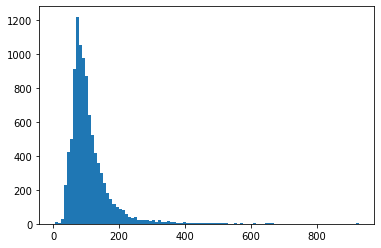

In [4]:

df_ads.loc[df_ads['price_type'] == "", 'price_type'] = "Normal"

df_ads = df_ads.drop(df_ads[df_ads.bathrooms>=8].index)
df_ads = df_ads.drop(df_ads[df_ads.beds>=10].index)
df_ads = df_ads.drop(df_ads[df_ads.property_type=='site'].index)
df_ads.loc[df_ads['surface'] > 1000, 'surface'] = np.nan
df_ads = df_ads.drop(df_ads[df_ads.dist_to_centre > 30].index)

plt.hist(df_ads.surface, bins = 100)
plt.show()

Calculating and plotting the log price per square meter

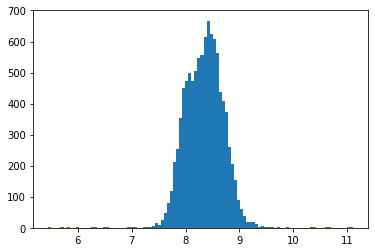

In [5]:
df_ads['price_sqm'] = np.log(df_ads.price / df_ads.surface)

plt.hist(df_ads.price_sqm, bins = 100)
plt.show()


Log transforming the price and plotting

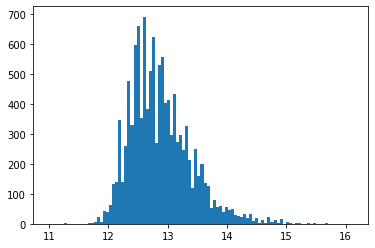

In [6]:
df_ads['price'] = np.log(df_ads.price)
plt.hist(df_ads.price, bins = 100)
plt.show()


Dropping rows with missing price

In [7]:
df_ads = df_ads.dropna(subset=['price'])
#df_ads = df_ads.dropna(subset=['price_sqm'])


Splitting data into training and testing

In [8]:
y = df_ads['price']
X = df_ads.drop(['price','price_sqm'], axis=1)
#X = df_ads.drop('surface', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing pipeline

Creating a list of categorical features and a list of numeric features. Both sets of features will be transformed and imputed differently. The categorical features need to be encoded to binary variables.

In [9]:
categorical_features = df_ads.columns[df_ads.dtypes==object].tolist()
categorical_features.append('month')

numeric_features = list(df_ads.columns)
for x in categorical_features:
    numeric_features.remove(x)

numeric_features.remove('price')
numeric_features.remove('price_sqm')
#numeric_features.remove('surface')

Categorical varibales are imputed with the most frequent value and dummies are created using OneHotEncoder

In [10]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


Transform numerical columns by imputing missing values using K nearest neighbours. Especially the surface area is an important feature with a relatively high degree of missingness. KNN is a flexible non-parametric method of imputation. Standardisation afterwards.

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())])

The columntransformer transforms numeric features differently than the categorial features.

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Fitting the models

The log of the housing price follows a quite a normal distribution. Also, many relationships can be assumed to have a linear effect, e.g. the surface area as well as any binary variables such as the neighbourhood. Coordinates are also included as features, which probably will not have a linear effect. A non-linear model such as random forest might use that better (see below)

An elasticnet is initialised and gridsearch is used to tune the parameters. 

In [13]:
        
steps_enet = [('preprocessor', preprocessor),
              ('reg', ElasticNet(max_iter=10000))]

pipeline_enet = Pipeline(steps_enet)

parametersGrid = {"reg__alpha": [0.001,0.01, 0.1,0.5,0.9,1],
                  "reg__l1_ratio": np.arange(0.1, 1, 0.1)}

grid_enet = GridSearchCV(pipeline_enet, parametersGrid, scoring='r2', cv=5, n_jobs=-1)


First up is the elastic net. The elastic net is tuned on the basis of R2 and the output below shows the R2 and the RMSE of the testing data.

In [14]:
grid_enet.fit(X_train, y_train)

best_model = grid_enet.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tuned best parameters: {}".format(grid_enet.best_params_))
print("Tuned R squared: {:.4f}".format(r2))
print("Tuned RMSE: {:.4f}".format(rmse))

Tuned best parameters: {'reg__alpha': 0.001, 'reg__l1_ratio': 0.1}
Tuned R squared: 0.8663
Tuned RMSE: 0.1930


The low alpha and L1 ratio shows that no penalty is needed because there is little risk of overfitting and that simple linear regression is probably better. 

In [15]:
def densplot(title,text_x,text_y):
    sns.distplot(y_test, hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = "Observed")
    sns.distplot(y_pred, hist = False, kde = True,
                    kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = "Predicted")     
    plt.xlabel("log(price)")
    plt.title(title)
    plt.text(text_x, text_y, "R2: {:.3f}".format(r2) + "\n" + "RMSE: {:.3f}".format(rmse), 
    horizontalalignment='right', size='medium', color='black')
    plt.tight_layout()
    plt.show() 

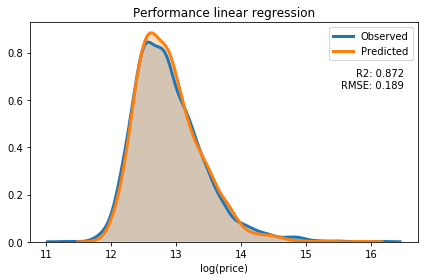

R2 linear regression training data: 0.870862
RMSE linear regression training data: 0.186360


In [16]:

steps_linreg = [('preprocessor', preprocessor),
                ('linreg', LinearRegression())]

pipeline_linreg = Pipeline(steps_linreg)

pipeline_linreg.fit(X_train, y_train)
y_pred = pipeline_linreg.predict(X_test)

r2 = pipeline_linreg.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

densplot("Performance linear regression", 16.5, 0.65)

y_pred_train = pipeline_linreg.predict(X_train)
r2 = pipeline_linreg.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("R2 linear regression training data: {:4f}".format(r2))
print("RMSE linear regression training data: {:4f}".format(rmse))
    

This shows that the R2 of the linear model performs the best and is superior to elasticnet. This shows that overfitting is not a problem. Also the scores of the training data are similar to that of the testing data.

Here a random forest estimator is initialised, following the same preprocessing steps. 

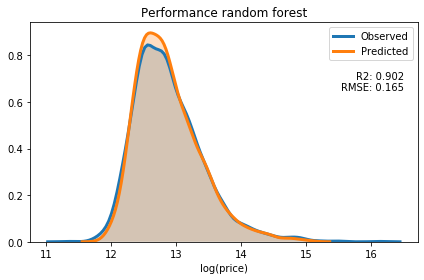

OOB score random forest: 0.886914
R2 random forest training data: 0.984230
RMSE random forest training data: 0.065125


In [17]:
steps_rf = [('preprocessor', preprocessor),
            ('rf', RandomForestRegressor(n_estimators=50,
                                         random_state=42, n_jobs=-1, oob_score=True))]

pipeline_rf = Pipeline(steps_rf)

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

r2 = pipeline_rf.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

densplot('Performance random forest', 16.5, 0.65)    

print("OOB score random forest: {:4f}".format(pipeline_rf.named_steps['rf'].oob_score_))

y_pred = pipeline_rf.predict(X_train)
r2 = pipeline_rf.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("R2 random forest training data: {:4f}".format(r2))
print("RMSE random forest training data: {:4f}".format(rmse))

The random forest shows the highest scores compared to the regression model, though it is only marginally higher. However, the scores on the testing data are substantially higher than the scores on the training data, which points to overfitting.

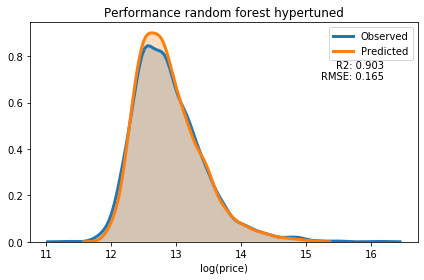

Tuned best parameters: {'rf__n_estimators': 500}
R2 random forest hypertuned training data: 0.985296
RMSE random forest hypertuned training data: 0.062884


In [18]:
params_rf = {'rf__n_estimators': [300,500,700]}

grid_rf = GridSearchCV(estimator=pipeline_rf,
                       param_grid=params_rf,
                       scoring='r2',
                       cv=5,
                       n_jobs=-1)

grid_rf.fit(X_train,y_train)

best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_pred,y_test))

densplot('Performance random forest hypertuned', 16.2, 0.7)    
print("Tuned best parameters: {}".format(grid_rf.best_params_))

y_pred = best_model.predict(X_train)
r2 = best_model.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("R2 random forest hypertuned training data: {:4f}".format(r2))
print("RMSE random forest hypertuned training data: {:4f}".format(rmse))

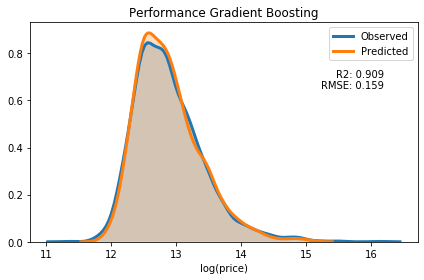

R2 gradient boosting training data: 0.994855
RMSE gradient boosting training data: 0.037198


In [19]:
steps_gb = [('preprocessor', preprocessor),
            ('gb', GradientBoostingRegressor(n_estimators=200, max_depth=10, random_state=42))]

pipeline_gb = Pipeline(steps_gb)

pipeline_gb.fit(X_train, y_train)
y_pred = pipeline_gb.predict(X_test)

r2 = pipeline_gb.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

densplot('Performance Gradient Boosting', 16.2, 0.65)    

y_pred = pipeline_gb.predict(X_train)
r2 = pipeline_gb.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("R2 gradient boosting training data: {:4f}".format(r2))
print("RMSE gradient boosting training data: {:4f}".format(rmse))

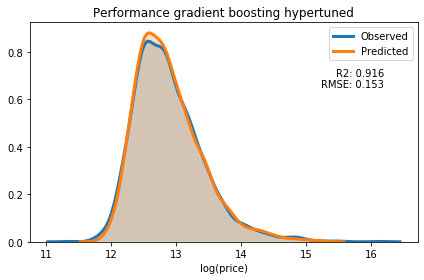

Tuned best parameters: {'gb__max_depth': 7, 'gb__n_estimators': 900}
R2 gradient boosting hypertuned training data: 0.995193
RMSE gradient boosting hypertuned training data: 0.035957


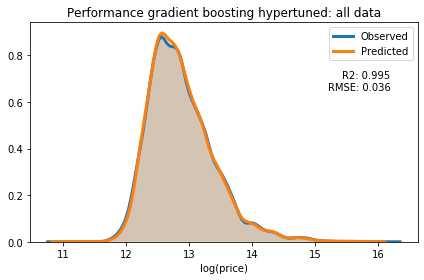

In [20]:
params_gb = {'gb__n_estimators': [700,900,1200],
             'gb__max_depth': [3,5,7,9]}

grid_gb = GridSearchCV(estimator=pipeline_gb,
                       param_grid=params_gb,
                       scoring='r2',
                       cv=3,
                       n_jobs=-1)

grid_gb.fit(X_train,y_train)

best_model = grid_gb.best_estimator_

y_pred = best_model.predict(X_test)

r2 = best_model.score(X_test,y_test)
rmse = np.sqrt(mean_squared_error(y_pred,y_test))

densplot('Performance gradient boosting hypertuned', 16.2, 0.65)    
print("Tuned best parameters: {}".format(grid_gb.best_params_))

y_pred = best_model.predict(X_train)
r2 = best_model.score(X_train,y_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("R2 gradient boosting hypertuned training data: {:4f}".format(r2))
print("RMSE gradient boosting hypertuned training data: {:4f}".format(rmse))

y_pred = best_model.predict(X)
y_test = y
densplot('Performance gradient boosting hypertuned: all data', 16.2, 0.65)    

Hypertuning improves the model just a little.

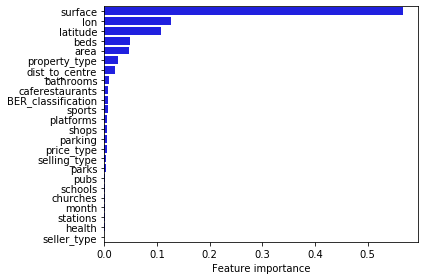

In [21]:
categorical_transformer.fit_transform(X_train[categorical_features])
catnames_array = categorical_transformer.named_steps['onehot'].get_feature_names().tolist()

catnames = []
for i in catnames_array:
    catnames.append(i)
names = numeric_features + catnames

importances_gb = pd.DataFrame(best_model.named_steps['gb'].feature_importances_, index = names)
importances_gb['var'] = importances_gb.index.str[:3]
importances_gb.loc[0:15,'var'] = importances_gb.index[0:15]
importances_gb.loc[importances_gb['var'].str.contains('x0_'), 'var'] = 'area'
importances_gb.loc[importances_gb['var'].str.contains('x1_'), 'var'] = 'property_type'
importances_gb.loc[importances_gb['var'].str.contains('x2_'), 'var'] = 'BER_classification'
importances_gb.loc[importances_gb['var'].str.contains('x3_'), 'var'] = 'seller_type'
importances_gb.loc[importances_gb['var'].str.contains('x4_'), 'var'] = 'selling_type'
importances_gb.loc[importances_gb['var'].str.contains('x5_'), 'var'] = 'price_type'
importances_gb.loc[importances_gb['var'].str.contains('x6_'), 'var'] = 'month'
importances_gb.loc[importances_gb['var'].str.contains('x7_'), 'var'] = 'parking'

df = importances_gb.groupby('var').sum().sort_values(by=0, ascending=False)
df['var'] = df.index

sns.barplot(x=0, y='var', data=df, color='b')
plt.xlabel("Feature importance")
plt.ylabel(None)
plt.tight_layout()
plt.show()


This shows that surface area is by far the most important feature, as one would expect. Gradient boosting is able to use longitude and latitude very effectively as well. This makes sense: where linear regression only has one coefficient for longitude and one for latitude, trees can effectively devide the entire city into blocks with differing price levels. 